In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 8

from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

# Helper Functions

In [6]:
def missing_values(data,n):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(
        ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(n)

def test_train(train, test):
    train['source']= 'train'
    test['source'] = 'test'
    data=pd.concat([train, test],ignore_index=True)
    print(data.shape)
    return data

def get_column_type(data):
    obj = []
    int_cont = []
    for name in data.columns:
        if data[name].dtype is np.dtype( 'O') and name != 'source':
            obj.append(name)
        else:
            int_cont.append(name)
    return obj, int_cont

def dummy_data(data, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(data[x], prefix=x, dummy_na=False)
        data = data.drop(x,1)
        data = pd.concat([data, dummies], axis=1)
    return data

zoneToStateMapping = {'SW':['lagos', 'oyo', 'ekiti', 'ogun', 'ondo', 'osun'],
                      'SS':['akwa ibom', 'bayelsa', 'cross river', 'rivers', 'delta', 'edo'],
                     'SE':['abia','anambra','ebonyi', 'enugu', 'imo'],
                     'NW':['jigawa','kaduna','kano','katsina','kebbi','sokoto','zamfara'],
                     'NE':['adamawa','bauchi','borno','gombe','yobe','taraba'],
                     'NC':['benue','kogi','kwara','nassarawa','niger','plateau','fct']}

def groupByZone(state):
    state = state.lower()
    for zone in zoneToStateMapping:
        if state in zoneToStateMapping[zone]:
            return zone
        else:continue

def plot_correlation_matrix(data, columns):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(data[columns].astype(float).corr(),linewidths=0.1,vmax=1.0,
                square=True, cmap=colormap, linecolor='white', annot=True)

def changeTargetTypeToInt(value):
    return int(value)

def getIntegerFromStringValue(value):
    if len(value)>3:
        return 6
    else:
        return value

# Get data

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = test_train(train, test)

(54808, 20)


In [8]:
data.head(2)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,Previous_IntraDepartmental_Movement,Promoted_or_Not,Qualification,State_Of_Origin,Targets_met,Training_score_average,Trainings_Attended,Year_of_birth,Year_of_recruitment,source
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,No,0.0,"MSc, MBA and PhD",ANAMBRA,1,41,2,1986,2011,train
1,Agency and others,Customer Support and Field Operations,YAK/S/00002,Yes,Male,12.5,Married,0,No,0,No,0.0,First Degree or HND,ANAMBRA,0,52,2,1991,2015,train


In [9]:
missing_values(data,3)

,Total,Percent
Promoted_or_Not,16496,30.097796
Qualification,2409,4.395344
source,0,0.000000


In [10]:
train.Past_Disciplinary_Action.value_counts()

No     38161
Yes      151
Name: Past_Disciplinary_Action, dtype: int64

In [11]:
data.columns

Index(['Channel_of_Recruitment', 'Division', 'EmployeeNo', 'Foreign_schooled',
       'Gender', 'Last_performance_score', 'Marital_Status',
       'No_of_previous_employers', 'Past_Disciplinary_Action',
       'Previous_Award', 'Previous_IntraDepartmental_Movement',
       'Promoted_or_Not', 'Qualification', 'State_Of_Origin', 'Targets_met',
       'Training_score_average', 'Trainings_Attended', 'Year_of_birth',
       'Year_of_recruitment', 'source'],
      dtype='object')

In [12]:
categorical =['Channel_of_Recruitment','Division','Foreign_schooled','Gender','Marital_Status',
              'Previous_Award','Previous_IntraDepartmental_Movement','Qualification',
              'Past_Disciplinary_Action','zone']

In [13]:
Numerical = ['Last_performance_score','No_of_previous_employers','Targets_met',
             'Training_score_average','Trainings_Attended','Age_recurited','Years_in_company']

In [14]:
data['Age_recurited'] = data.Year_of_recruitment - data.Year_of_birth
data['Years_in_company'] = 2019 - data.Year_of_recruitment
data['Qualification'] = data['Qualification'].fillna(value='something_here')
data['zone'] = data.State_Of_Origin.apply(lambda x: groupByZone(x))
data['No_of_previous_employers'] = data.No_of_previous_employers.apply(lambda x: getIntegerFromStringValue(x))
data.drop(['Year_of_recruitment','Year_of_birth','State_Of_Origin'], 1,inplace=True)
data['Previous_Award'] = data['Previous_Award'].astype(str)
data['No_of_previous_employers'] = data['No_of_previous_employers'].astype(int)

In [15]:
data.head(1)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,Previous_IntraDepartmental_Movement,Promoted_or_Not,Qualification,Targets_met,Training_score_average,Trainings_Attended,source,Age_recurited,Years_in_company,zone
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,No,0.0,"MSc, MBA and PhD",1,41,2,train,25,8,SE


In [16]:
for c in ['Age_recurited', 'Years_in_company', 'Training_score_average']:
    data[c] = np.log1p(data[c])

What affects promotion most is the Last Performance Score and Training Score average,
this can be seen in the correlation matrix above.

In [17]:
data.head(1)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,Previous_IntraDepartmental_Movement,Promoted_or_Not,Qualification,Targets_met,Training_score_average,Trainings_Attended,source,Age_recurited,Years_in_company,zone
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,No,0.0,"MSc, MBA and PhD",1,3.73767,2,train,3.258097,2.197225,SE


In [18]:
to_dummy = [ i for i in categorical if i not in ['EmployeeNo']]
data = dummy_data(data, to_dummy)

In [19]:
data.shape

(54808, 45)

In [20]:
train = data.loc[data['source']=='train']
train['Promoted_or_Not'] = train['Promoted_or_Not'].apply(lambda value: changeTargetTypeToInt(value))
test = data.loc[data['source']=='test']
train.drop('source',axis=1,inplace=True)
test.drop(['source','Promoted_or_Not'],axis=1,inplace=True)

# Save the already processed data

In [21]:
test.to_csv('ProcessedTestData.csv', index_label=False)
train.to_csv('ProcessedTrainData.csv', index_label=False)

# Data Splitting

In [22]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Promoted_or_Not'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Promoted_or_Not'], cv=cv_folds, scoring='f1_micro')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Promoted_or_Not'].values, dtrain_predictions))
    print("F1 (Train): %f" % metrics.f1_score(dtrain['Promoted_or_Not'], dtrain_predictions, average='micro'))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),
                                                                                 np.min(cv_score),np.max(cv_score)))
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize'] = 40, 12
         
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


In [24]:
IDcol = 'EmployeeNo'
target = 'Promoted_or_Not'
predictors = [x for x in train.columns if x not in [target, IDcol]]
# gbm0 = GradientBoostingClassifier(random_state=10)
# modelfit(gbm0, train, predictors)

In [137]:
param_test1 = {'n_estimators':range(160,241,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=400,
                                  min_samples_leaf=40,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=40,
                                                  min_samples_split=400,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pre

In [138]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 190}, 0.9408017783176362)

In [20]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=190,
                                                  n_iter_no_change=None,
                                                  presor

In [23]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 9, 'min_samples_split': 1000}, 0.9414021233220474)

In [29]:
param_test3 = {'min_samples_leaf':range(1,32,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,max_depth=9,
                                                    max_features='sqrt', subsample=0.8, random_state=10,min_samples_split=1800),
                       param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=9,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=1800,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=190,
                                                  n_iter_no_change=None,
                                                  pre

In [30]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 11}, 0.9415326579835199)


Model Report
Accuracy : 0.9445
F1 (Train): 0.944534
CV Score : Mean - 0.9415327 | Std - 0.001712382 | Min - 0.9383973 | Max - 0.9434873


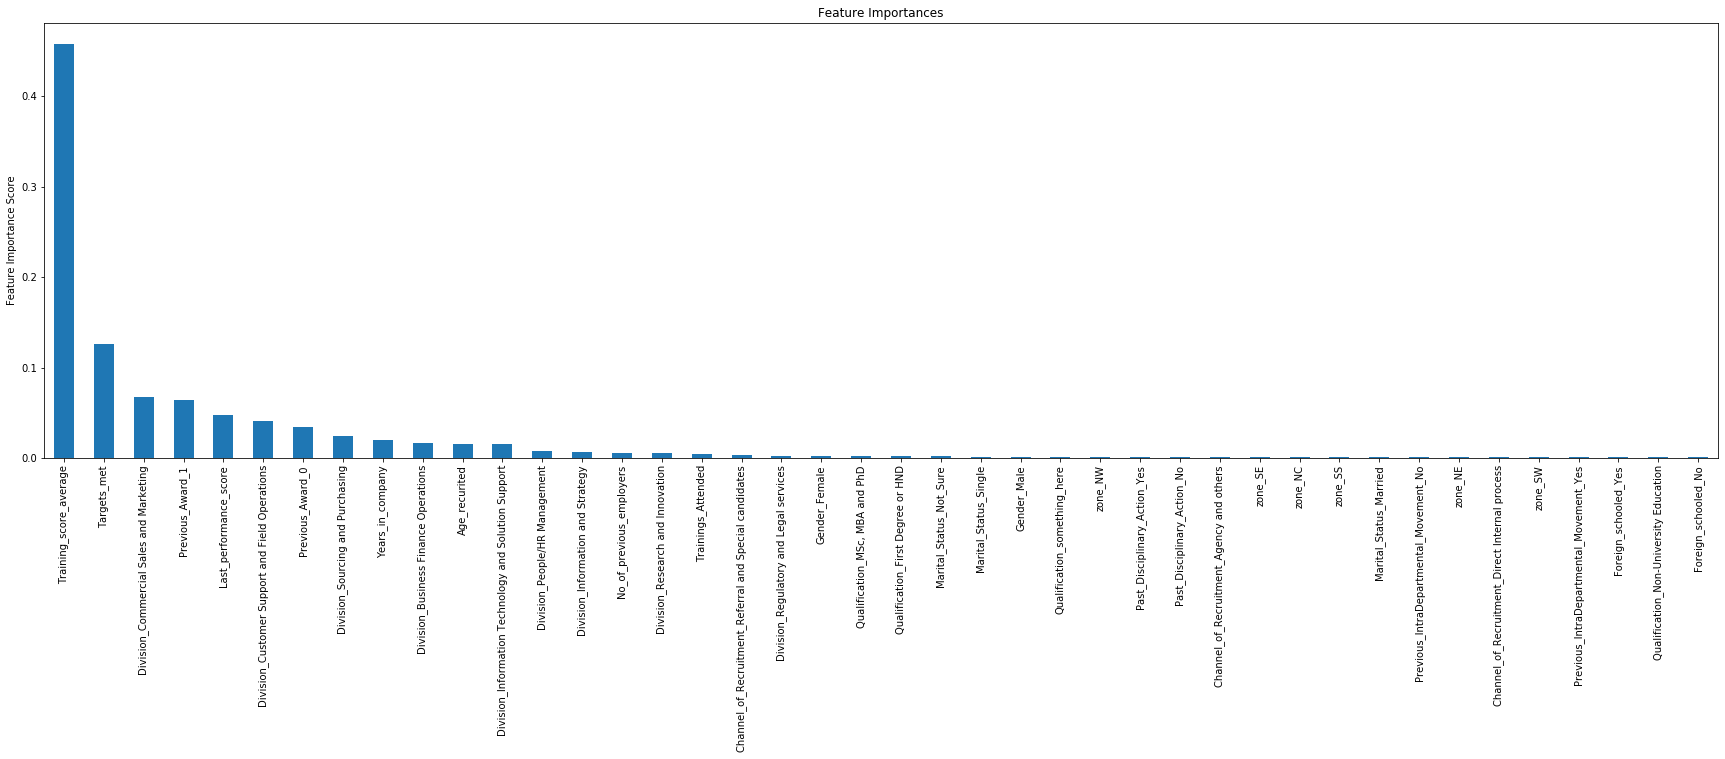

In [31]:
modelfit(gsearch3.best_estimator_, train, predictors)

In [32]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,max_depth=9, 
                            min_samples_split=1800, min_samples_leaf=11, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=9,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=11,
                                                  min_samples_split=1800,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=190,
                                                  n_iter_no_change=None,
                                                  pres

In [33]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 17}, 0.9423678809121718)

In [34]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,max_depth=9, 
                            min_samples_split=1800, min_samples_leaf=11, random_state=10, max_features=17),
                       param_grid = param_test5, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=9,
                                                  max_features=17,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=11,
                                                  min_samples_split=1800,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=190,
                                                  n_iter_no_change=None,
                                                  presor

In [35]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.9423678809121718)


Model Report
Accuracy : 0.9454
F1 (Train): 0.945448
CV Score : Mean - 0.9423679 | Std - 0.001584239 | Min - 0.940094 | Max - 0.9447925


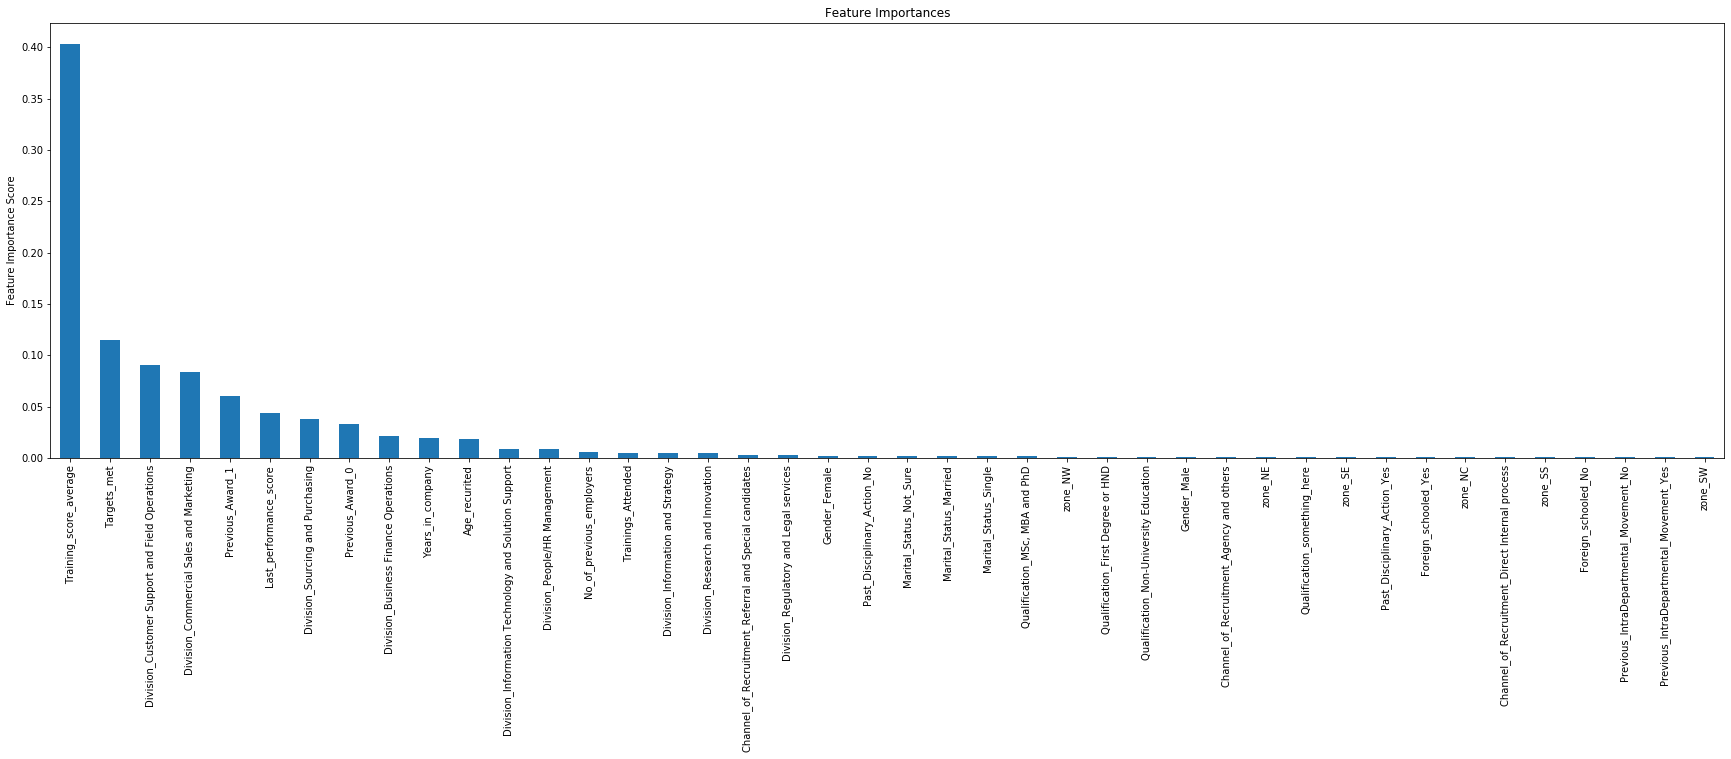

In [36]:
modelfit(gsearch5.best_estimator_, train, predictors)


Model Report
Accuracy : 0.9454
F1 (Train): 0.945448
CV Score : Mean - 0.9423679 | Std - 0.001584239 | Min - 0.940094 | Max - 0.9447925


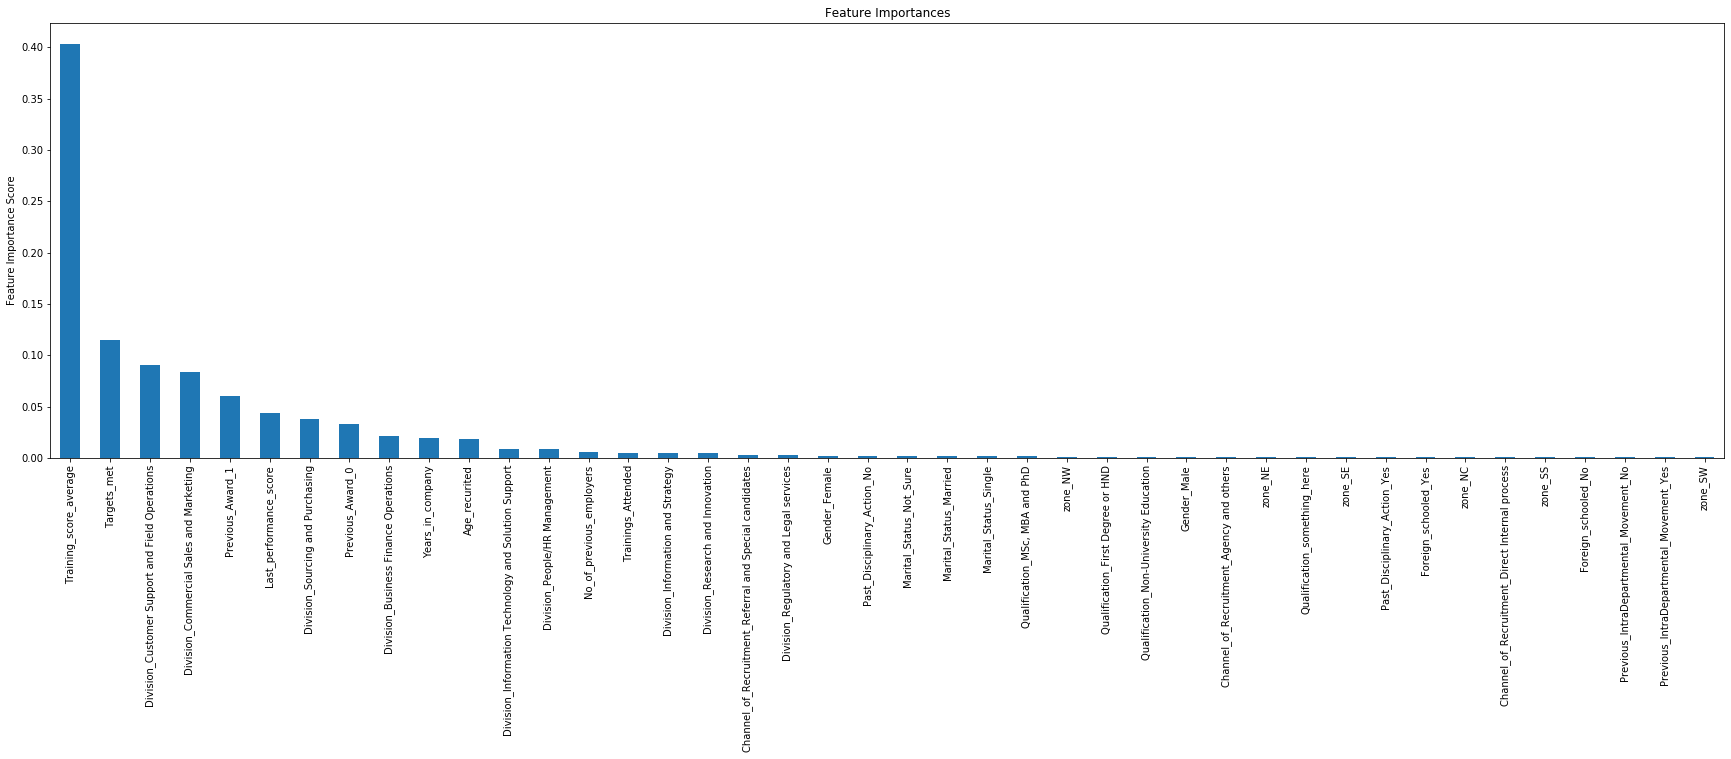

In [20]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,max_depth=9, min_samples_split=1800, 
                                         min_samples_leaf=11, subsample=0.8, random_state=10, max_features=17)
modelfit(gbm_tuned_1, train, predictors)

In [22]:
submission = pd.DataFrame()
submission['EmployeeNo'] = test['EmployeeNo']
submission['Promoted_or_Not'] = gbm_tuned_1.predict(test[predictors])

In [24]:
submission.to_csv('gbmSubmission.csv', index=False)

# Using Xgboost Classifier

In [25]:
from xgboost.sklearn import XGBClassifier

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Promoted_or_Not'],eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Promoted_or_Not'].values, dtrain_predictions))
    print("F1-Score (Train): %f" % metrics.f1_score(dtrain['Promoted_or_Not'], dtrain_predictions,average='micro'))
    
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize'] = 30, 10
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.945
F1-Score (Train): 0.945004


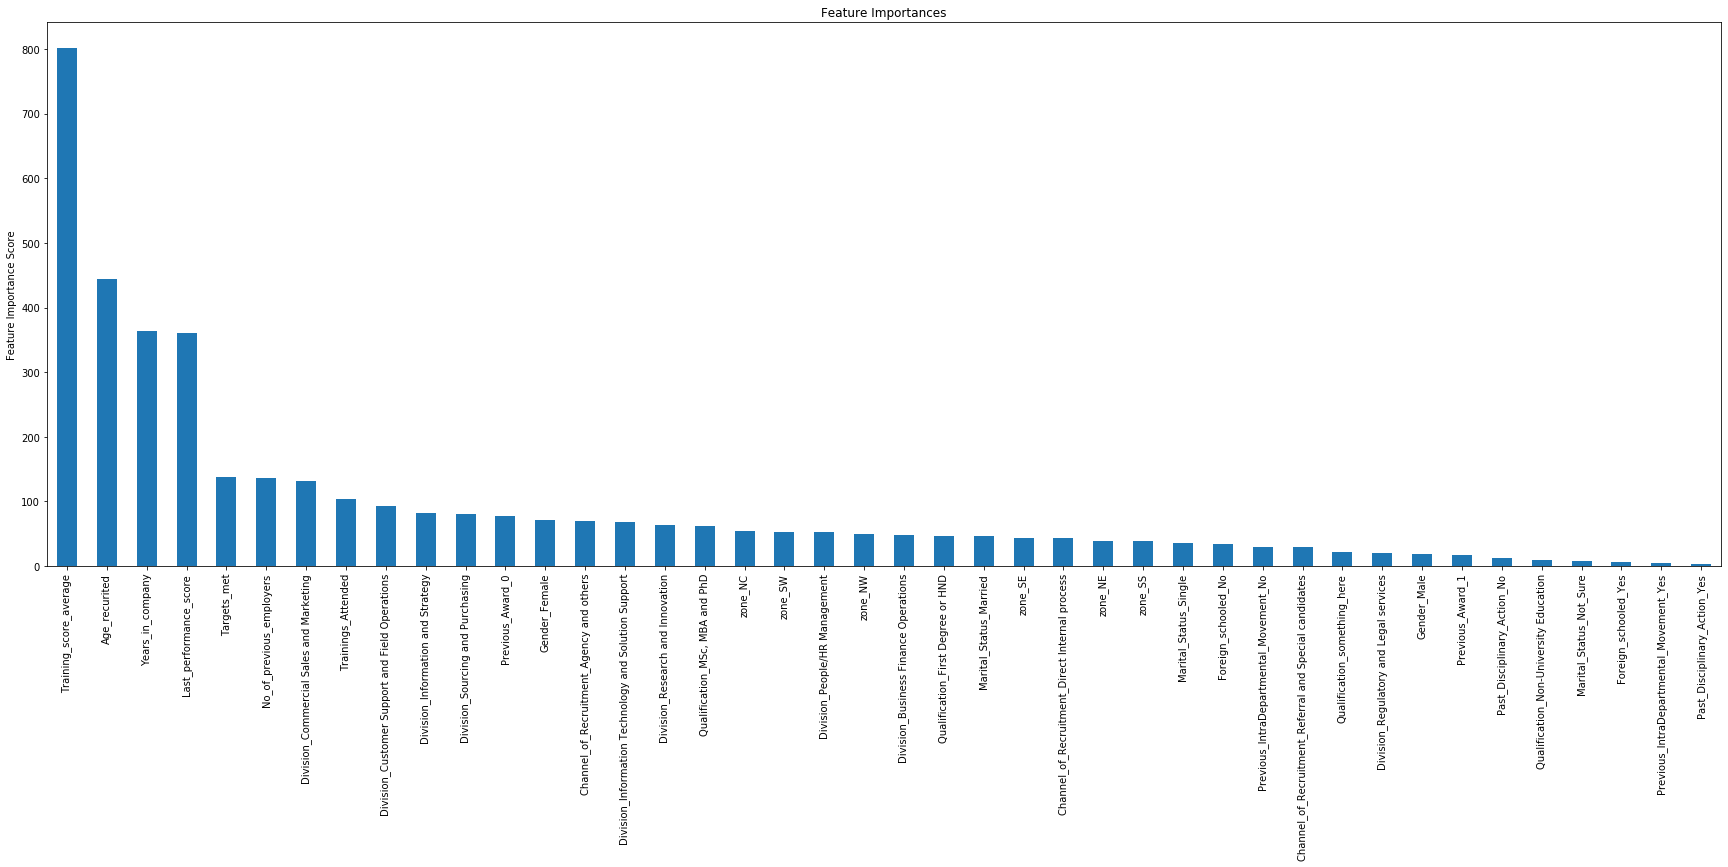

In [26]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, predictors)

In [28]:
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, retur

In [29]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 3}, 0.9422112706527184)

In [31]:
param_test2 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
                                        min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=3,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_micro', v

In [32]:
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.0}, 0.9422112706527184)


Model Report
Accuracy : 0.9447
F1-Score (Train): 0.944743


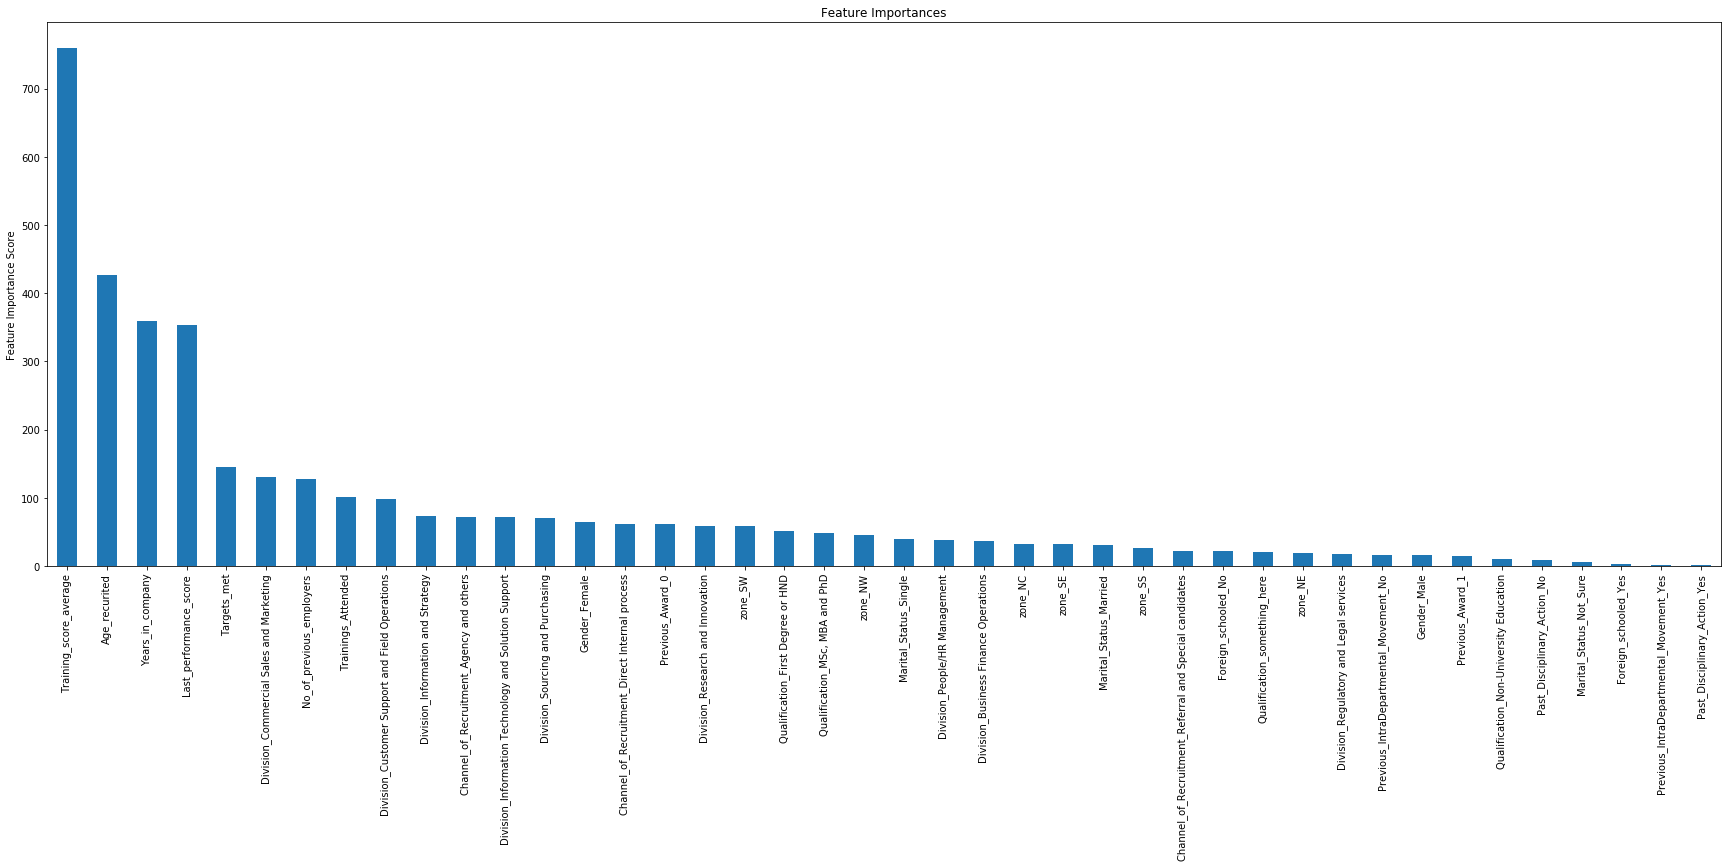

In [34]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, train, predictors)

In [35]:
param_test3 = {
    'subsample':[i/10.0 for i in range(5,10)],
    'colsample_bytree':[i/10.0 for i in range(5,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=3,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_job

In [36]:
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9424461690123807)

In [37]:
param_test4 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10,100]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=3,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_

In [38]:
gsearch4.best_params_, gsearch4.best_score_

({'reg_alpha': 1e-05}, 0.9424461690123807)


Model Report
Accuracy : 0.9447
F1-Score (Train): 0.944743


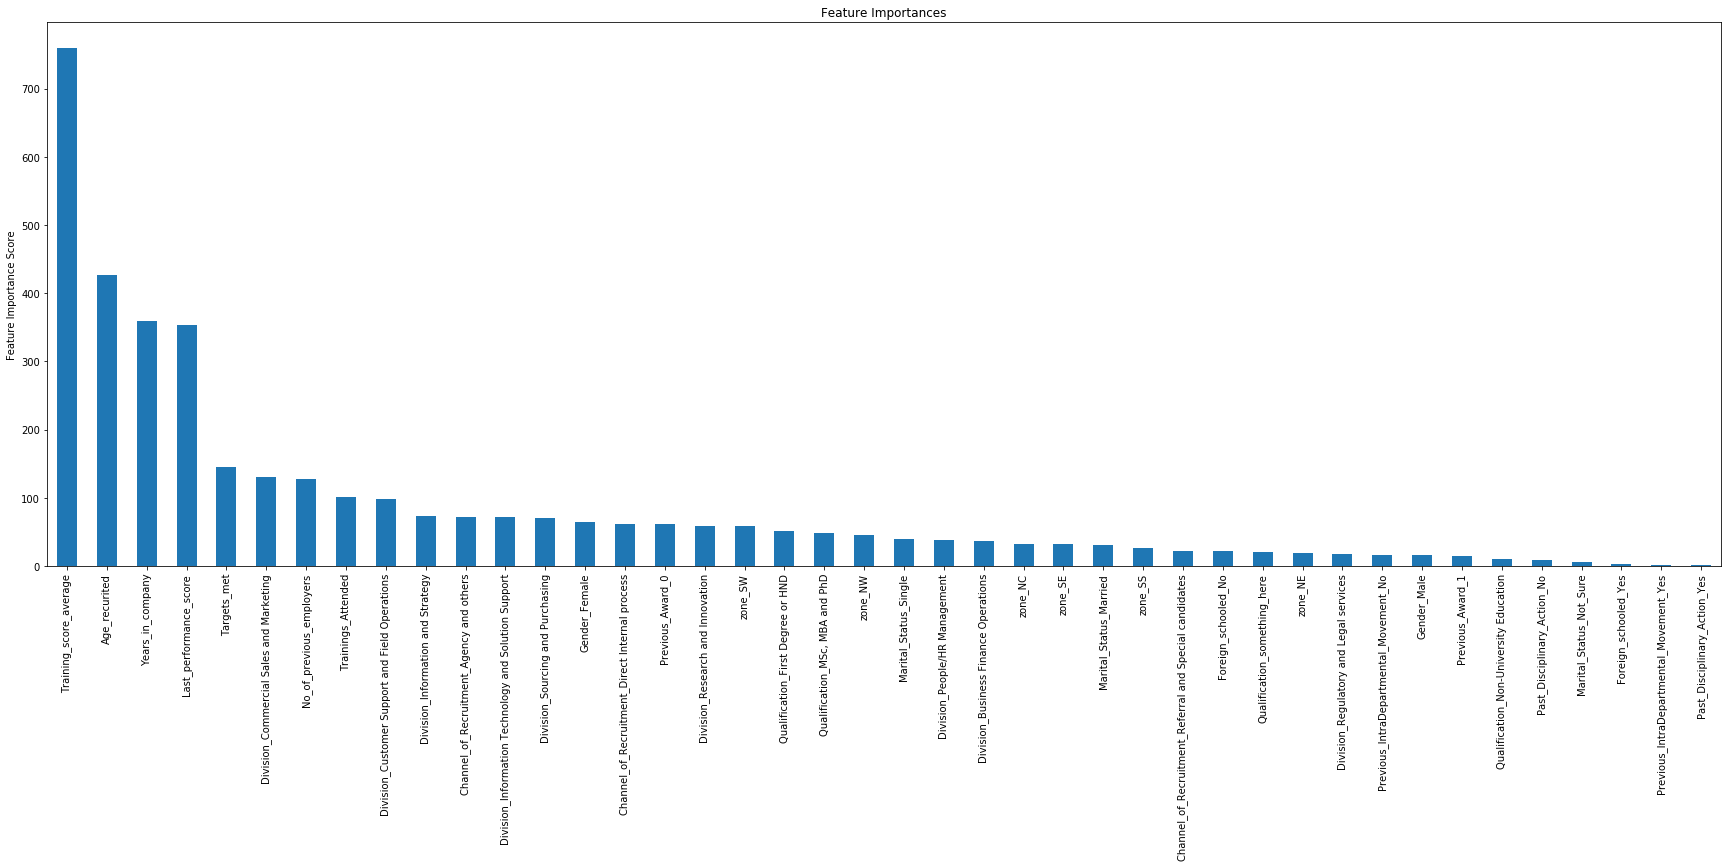

In [39]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1e-05,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, train, predictors)


Model Report
Accuracy : 0.9445
F1-Score (Train): 0.944534


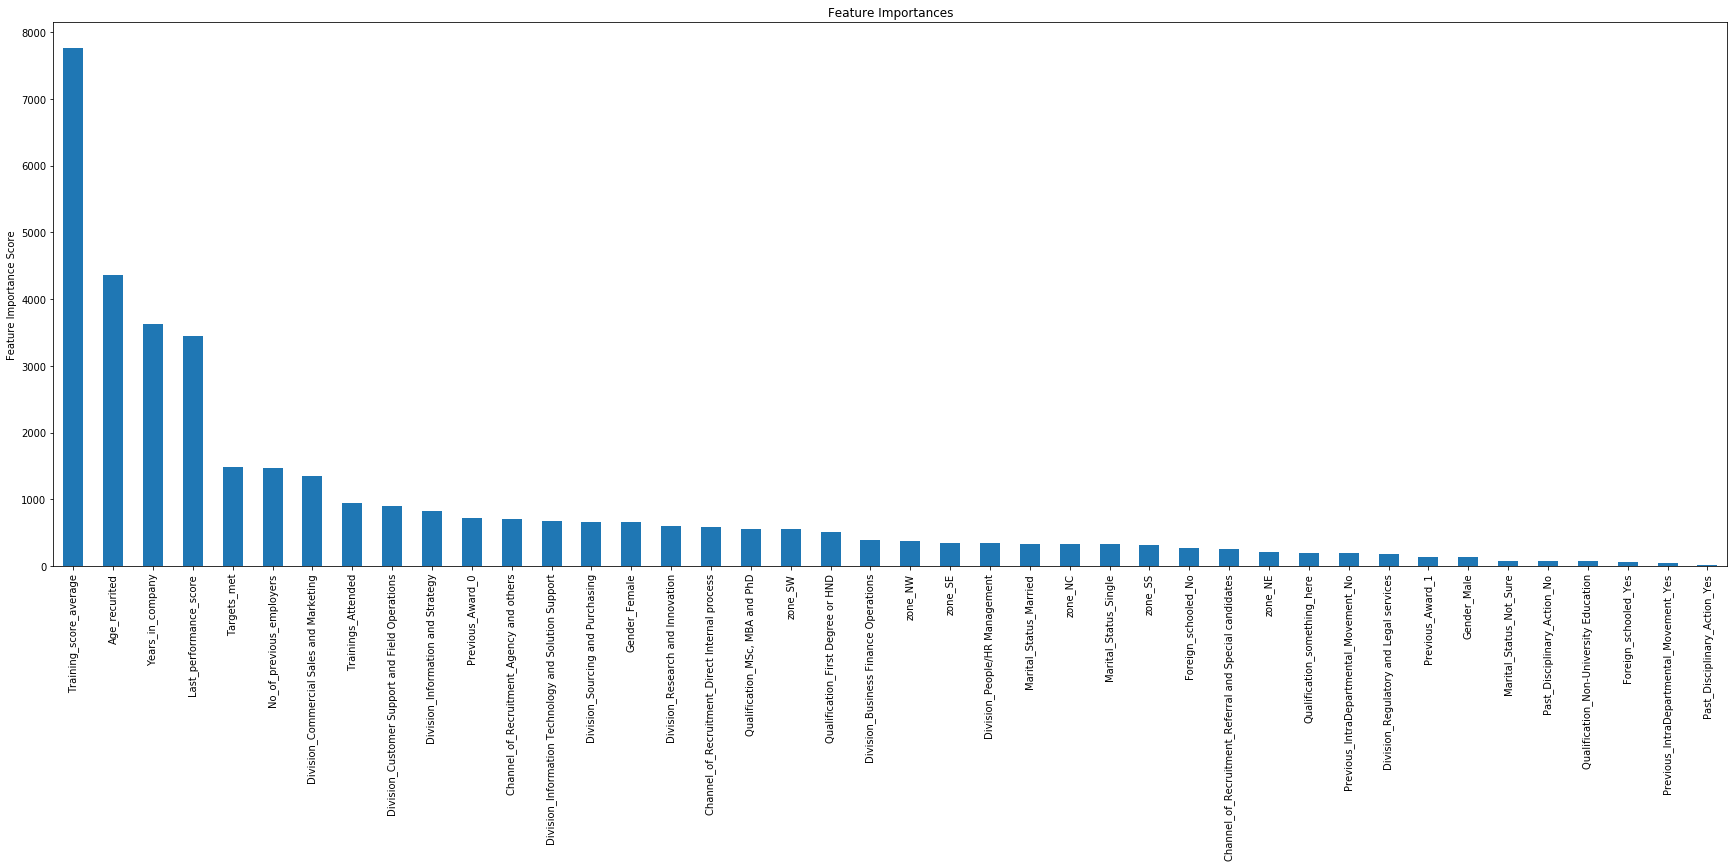

In [40]:
xgb4 = XGBClassifier(
        learning_rate =0.01,
        n_estimators=5000,
        max_depth=5,
        min_child_weight=3,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1e-05,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb4, train, predictors)

In [42]:
submission = pd.DataFrame()
submission['EmployeeNo'] = test['EmployeeNo']
submission['Promoted_or_Not'] = xgb4.predict(test[predictors])
submission.to_csv('xgbm4Submission.csv', index=False)

# RandomForest Algorithm

In [30]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [43]:
def acc_model(params):
    clf = RandomForestClassifier(**params)
    cv_score = cross_val_score(clf, train[predictors], train[target],scoring='f1_micro', cv=StratifiedKFold())
    return cv_score.mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(1,42)),
    'n_estimators': hp.choice('n_estimators', range(100,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best:                                            
0.9257151611423547                                   
{'criterion': 'gini', 'max_depth': 16, 'max_features': 3, 'n_estimators': 383}
new best:                                                                      
0.9262633127167454                                                             
{'criterion': 'gini', 'max_depth': 4, 'max_features': 29, 'n_estimators': 171} 
new best:                                                                      
0.926393810592752                                                              
{'criterion': 'gini', 'max_depth': 4, 'max_features': 38, 'n_estimators': 176} 
new best:                                                                      
0.9354771061370463                                                            
{'criterion': 'gini', 'max_depth': 13, 'max_features': 11, 'n_estimators': 308}
new best:                                                                       
0.94038418352

# LIGHTGBM

In [44]:
from sklearn.model_selection import KFold

from bayes_opt import BayesianOptimization
import lightgbm as lgb

In [49]:
def lgbcv(learning_rate, subsample, min_child_samples, max_depth,
                  colsample_bytree, min_child_weight, min_split_gain, 
                  lambda_l1, lambda_l2,bagging_freq, num_leaves,
                  silent=True, seed=1234):

    params = {                        
            'boosting_type': 'gbdt','objective': 'binary', 'metric':'binary_logloss',
            'max_depth': -1, 'num_leaves': int(num_leaves),
            'learning_rate': learning_rate, 'max_depth': int(max_depth),
            'min_child_samples': int(min_child_samples), 
           'subsample': subsample, 'colsample_bytree': colsample_bytree, 'bagging_seed': 11,
           'min_child_weight': min_child_weight,  'bagging_freq' : int(bagging_freq),
           'min_split_gain': min_split_gain,'lambda_l1': lambda_l1,'lambda_l2': lambda_l2,
           'nthread': 8
        }

                
    bst1 = lgb.train(params, trn_data, valid_sets=[trn_data, val_data], valid_names=['train','valid'],
                          num_boost_round= 5000, verbose_eval= 5000, early_stopping_rounds = 100)
    
    ypred = bst1.predict(x1)
    loss = metrics.log_loss(y1, ypred)

    return loss


In [50]:
param_list = list()
score_list = list()
nfolds = 5
folds = KFold(n_splits= nfolds, shuffle=True, random_state= 15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[predictors].values, train[target].values)):
    print('----')
    print("fold n°{}".format(fold_))
    
    x0,y0 = train[predictors].iloc[trn_idx], train[target][trn_idx]
    x1,y1 = train[predictors].iloc[val_idx], train[target][val_idx]
    
    
    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)
    # optimization
    lgbBO = BayesianOptimization(lgbcv, {'learning_rate': (0.0025, 0.05),'max_depth': (int(5), int(15)),
                                           'min_child_samples': (int(25), int(250)),'subsample': (0.2, 0.95),
                                            'colsample_bytree': (0.2, 0.95), 'min_child_weight': (int(1), int(150)),
                                            'min_split_gain': (0.1, 2),'num_leaves': (int(15),int(200)),
                                             'lambda_l1': (10, 200),'lambda_l2': (10, 200),
                                             'bagging_freq': (1,20)
                                                   })
    lgbBO.maximize(init_points= 25, n_iter= 45, xi=0.06)
    print('-' * 53)
    print('Final Results')

----
fold n°0
|   iter    |  target   | baggin... | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	train's binary_logloss: 0.264202	valid's binary_logloss: 0.254262
|  1        |  0.2543   |  18.49    |  0.3065   |  182.6    |  147.7    |  0.03609  |  13.31    |  218.6    |  28.83    |  1.999    |  123.4    |  0.5654   |
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	train's binary_logloss: 0.250615	valid's binary_logloss: 0.239997
|  2        |  0.24     |  17.71    |  0.6628   |  104.6    |  193.9    |  0.01888  |  7.487    |  120.4    |  136.5    |  1.936    |  80.16    |  0.7248   |
Training until v

KeyboardInterrupt: 

In [ ]:
print('LGB: %f' % lgbBO.res['max']['max_val']);  print('LGB: %s' % lgbBO.res['max']['max_params'])

    param_list.append(lgbBO.res['max']['max_params'])
    score_list.append(lgbBO.res['max']['max_val'])

##### TRY OUT XGBOOST, LGBM, CATBOOST, CNN AND NEURALNETS. ALSO NOTE: THE F1-MICRO IS THE SAME AS ACCURACY. 
##### The reason why I had to take a break was because of the weak internet connection experienced when installing XGBOOST.
##### At the moment we have a minimum of 0.9431 on Kaggle!!! Way to go!!!

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing


Y = train['Promoted_or_Not']
X = train[predictors]
# X = preprocessing.scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)


In [29]:
clfs = [ExtraTreesClassifier(),
    RandomForestClassifier()]
clfName = {1:'Extra Trees', 2:'Random Forests'}

for i in range(len(clfs)):
    scores = cross_val_score(clfs[i], X_train, Y_train.ravel(), cv=5, scoring = 'f1_micro')
    print ("mean validation F1 for",clfName[i+1], ":", 
           "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    clf = clfs[i].fit(X_train, Y_train.ravel())
    Y_pred = clf.predict(X_test)
    f1 = f1_score(Y_test, Y_pred,average='micro')
    print ('Test F1 for',clfName[i+1], ":", f1)

mean validation F1 for Extra Trees : Accuracy: 0.92 (+/- 0.00)
Test F1 for Extra Trees : 0.9220931749967376
mean validation F1 for Random Forests : Accuracy: 0.93 (+/- 0.01)
Test F1 for Random Forests : 0.9326634477358737


Text(0, 0.5, 'Feature Importance Score')

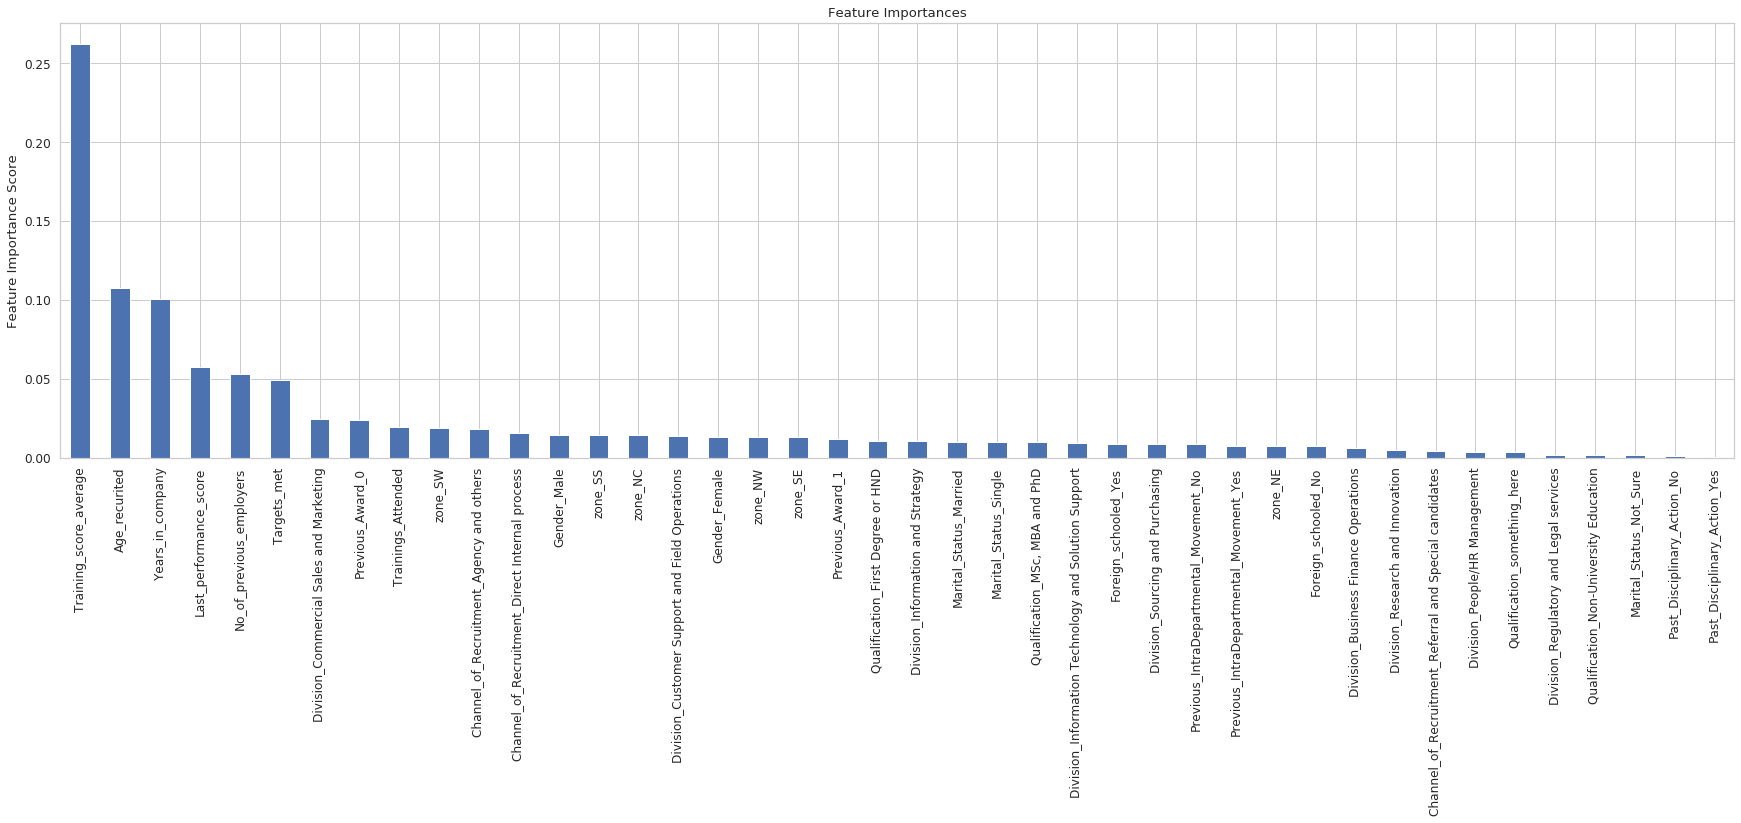

In [109]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 8
feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')